In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
import credit_pipeline.training as tr
import credit_pipeline.reject_inference as ri
import credit_pipeline.evaluate as ev

In [45]:
from mpi4py import MPI
import socket

In [46]:
df = pd.read_csv('data/asteroid-dataset.csv')
df, df_test = train_test_split(df, test_size=0.2, random_state=42)

/tmp/ipykernel_13808/1714289756.py:1: DtypeWarning: Columns (3,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/asteroid-dataset.csv')


<H1 style="color:Red">Columns Analysis</H1>

In [47]:
#get numeric columns
numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_columns;

In [48]:
df[numeric_columns];

In [49]:
df.columns

Index(['id', 'spkid', 'full_name', 'pdes', 'name', 'prefix', 'neo', 'pha', 'H',
       'diameter', 'albedo', 'diameter_sigma', 'orbit_id', 'epoch',
       'epoch_mjd', 'epoch_cal', 'equinox', 'e', 'a', 'q', 'i', 'om', 'w',
       'ma', 'ad', 'n', 'tp', 'tp_cal', 'per', 'per_y', 'moid', 'moid_ld',
       'sigma_e', 'sigma_a', 'sigma_q', 'sigma_i', 'sigma_om', 'sigma_w',
       'sigma_ma', 'sigma_ad', 'sigma_n', 'sigma_tp', 'sigma_per', 'class',
       'rms'],
      dtype='object')

<H2 style="color:Red">non numeric columns analysis</H2>

In [50]:
non_numeric_columns = df.select_dtypes(exclude='number').columns
non_numeric_columns

Index(['id', 'full_name', 'pdes', 'name', 'prefix', 'neo', 'pha', 'orbit_id',
       'equinox', 'class'],
      dtype='object')

In [51]:
nunique_cat_series = df[non_numeric_columns].nunique().sort_values(ascending=False)
discard_cat_columns = nunique_cat_series[(nunique_cat_series < 2) | (nunique_cat_series > 100)]
discard_cat_columns

id           766819
full_name    766819
pdes         766819
name          17661
orbit_id       3904
prefix            1
equinox           1
dtype: int64

Columns were discarded because they have too many unique values for a categorical column, or only one value.

In [52]:
# df[non_numeric_columns]['class'].value_counts()

<H3 style="color:Red">Convert Target column to numeric</H3>

In [53]:
df['pha'].value_counts()

pha
N    749330
Y      1643
Name: count, dtype: int64

In [54]:
df['pha'] = df['pha'].map({'N': 0, 'Y': 1})
df['pha'] = df['pha'].fillna(-1)  #drop later these values


In [55]:
df['pha'].value_counts()

pha
 0.0    749330
-1.0     15846
 1.0      1643
Name: count, dtype: int64

In [56]:
numeric_columns.append('pha')

<H2 style="color:Red">Identify importance of features</H2>

<H4 style="color:Red">Correlation analysis</H4>

In [57]:
df[numeric_columns].corr()['pha'].sort_values()

H                -0.034506
moid             -0.030113
diameter         -0.019826
diameter_sigma   -0.016068
spkid            -0.011536
ma               -0.008824
q                -0.002147
sigma_e          -0.000363
sigma_q          -0.000329
sigma_i          -0.000283
sigma_n          -0.000186
sigma_om         -0.000164
sigma_a          -0.000158
sigma_per        -0.000137
sigma_ad         -0.000135
sigma_w          -0.000074
sigma_ma         -0.000074
sigma_tp         -0.000073
per_y             0.000350
per               0.000350
a                 0.000491
om                0.001165
ad                0.001258
w                 0.001695
tp                0.003641
tp_cal            0.003677
i                 0.003927
rms               0.012657
epoch_cal         0.014871
epoch             0.016908
epoch_mjd         0.016908
albedo            0.018955
n                 0.055065
e                 0.060528
moid_ld           0.079452
pha               1.000000
Name: pha, dtype: float64

<Axes: >

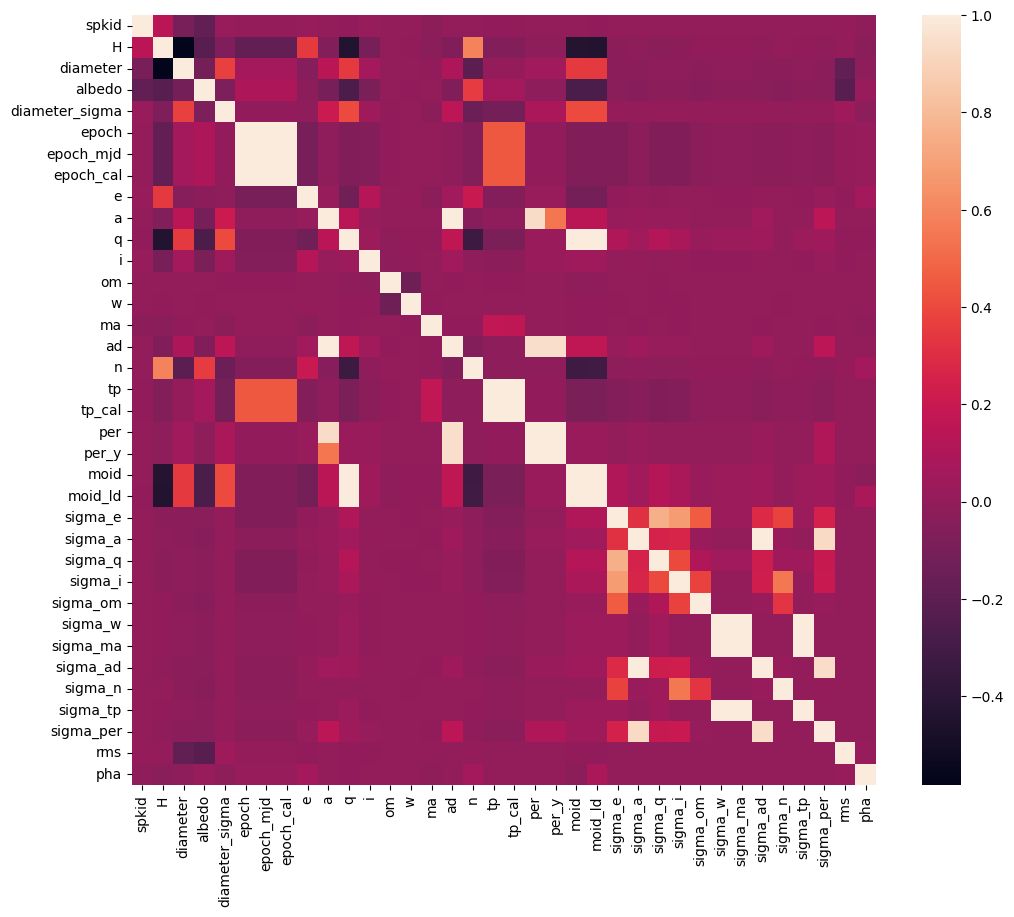

In [58]:
plt.figure(figsize=(12, 10))  # Adjust dimensions as needed
sns.heatmap(df[numeric_columns].corr(), annot=False, fmt=".2f")


<H4 style="color:Red">Chi Square Analysis</H4>

In [59]:
df = df.loc[df['pha'] != -1]

X = df[numeric_columns].drop(columns=['pha'])
y = df['pha']


X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [60]:
from sklearn.feature_selection import chi2

In [61]:
X_train.isnull().sum().sort_values(ascending=False).head()

albedo            514430
diameter_sigma    513791
diameter          513716
H                   3986
sigma_ad               3
dtype: int64

In [62]:
X_train_temp = X_train.fillna(X_train.mean())

In [63]:
# Define o filtro para selecionar colunas onde o valor mínimo é maior ou igual a 0
mask_min = X_train_temp.describe().T['min'] >= 0

# Aplica a máscara ao dataframe para retornar apenas as colunas correspondentes
X_train_temp = X_train_temp.loc[:, mask_min]


In [64]:
chi2_stats, p_values = chi2(X_train_temp, y_train)

In [65]:
chi2_stats.round(0).astype(int)

array([     4569438,          794,           59,            0,
                  3,           10,          425,          934,
               1214,         1474,         3384,          305,
                 14,          141,          458,            9,
                851,      1929435,         5282,         1803,
             701674,          979,        25027,        30900,
                582,         6568,   2542592975,   2542529215,
              35687,           43, 805893401686,    135029960,
                 17])

In [66]:
p_values.round(3) 

array([0.   , 0.   , 0.   , 0.563, 0.077, 0.001, 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.003, 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   ])

/tmp/ipykernel_13808/3071766456.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=X_train_temp.columns, y=chi2_stats, palette="viridis")


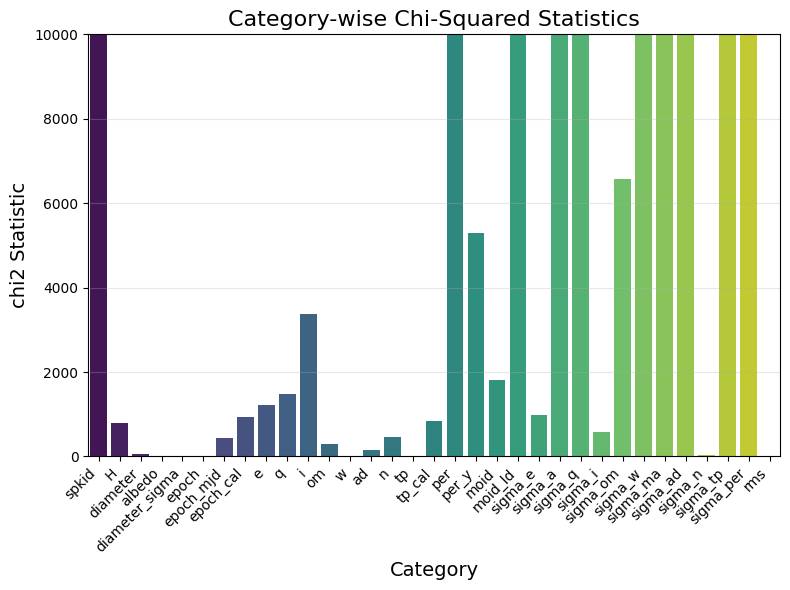

In [67]:
# Create the plot
plt.figure(figsize=(8, 6))
sns.barplot(x=X_train_temp.columns, y=chi2_stats, palette="viridis")

# Enhance aesthetics
plt.title("Category-wise Chi-Squared Statistics", fontsize=16)
plt.xlabel("Category", fontsize=14)
plt.ylabel("chi2 Statistic", fontsize=14)
plt.grid(axis='y', alpha=0.3)
plt.ylim(0, 10000)  # Limit y-axis to better visualize the differences
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()

# Show the plot
plt.show()


/tmp/ipykernel_13808/3445438888.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=X_train_temp.columns, y=p_values, palette="viridis")


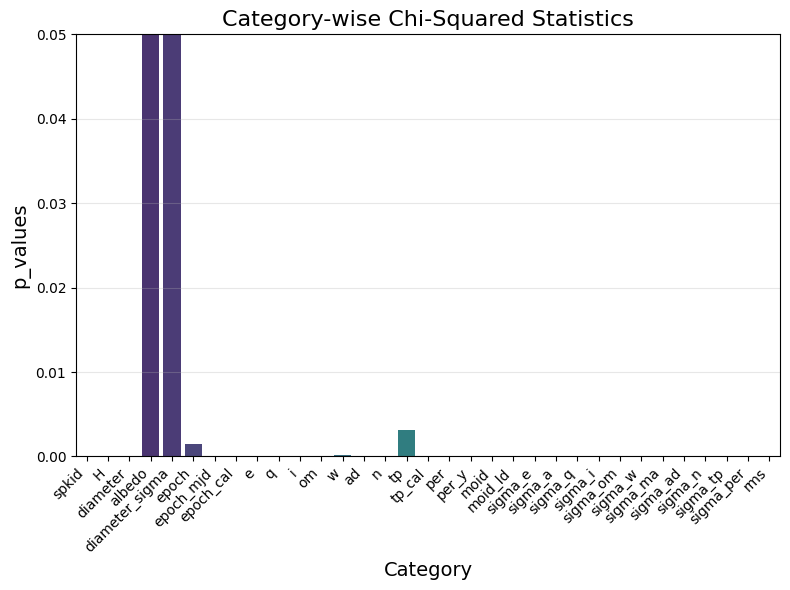

In [68]:
# Create the plot
plt.figure(figsize=(8, 6))
sns.barplot(x=X_train_temp.columns, y=p_values, palette="viridis")

# Enhance aesthetics
plt.title("Category-wise Chi-Squared Statistics", fontsize=16)
plt.xlabel("Category", fontsize=14)
plt.ylabel("p_values", fontsize=14)
plt.grid(axis='y', alpha=0.3)
plt.ylim(0, 0.05)  # Limit y-axis to better visualize the differences
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()

# Show the plot
plt.show()

In [69]:
from sklearn.feature_selection import r_regression

In [70]:
X_train_temp = X_train.fillna(X_train.mean())

In [71]:
r_value = r_regression(X_train_temp, y_train)

In [72]:
r_value = pd.Series(r_value, index=X_train_temp.columns)


In [73]:
r_value.sort_values(ascending=False)

e                 0.191074
n                 0.167914
H                 0.083232
i                 0.033952
albedo            0.006446
om                0.002842
ma                0.001145
sigma_tp         -0.000078
sigma_ma         -0.000079
sigma_w          -0.000079
sigma_ad         -0.000142
sigma_per        -0.000146
sigma_om         -0.000160
sigma_a          -0.000164
sigma_n          -0.000170
per_y            -0.000243
per              -0.000243
sigma_i          -0.000275
sigma_q          -0.000336
sigma_e          -0.000392
w                -0.000628
spkid            -0.000784
ad               -0.001071
rms              -0.001159
a                -0.002211
tp               -0.003728
tp_cal           -0.003845
diameter_sigma   -0.004729
diameter         -0.006587
epoch_cal        -0.009105
epoch            -0.009125
epoch_mjd        -0.009126
moid_ld          -0.029941
moid             -0.029941
q                -0.035188
dtype: float64

In [74]:
r_value[(r_value.abs() >= 0.01)].sort_values(ascending=False)

e          0.191074
n          0.167914
H          0.083232
i          0.033952
moid_ld   -0.029941
moid      -0.029941
q         -0.035188
dtype: float64

In [75]:
discard_num_columns = r_value[(r_value.abs() < 0.01)]
discard_num_columns

spkid            -0.000784
diameter         -0.006587
albedo            0.006446
diameter_sigma   -0.004729
epoch            -0.009125
epoch_mjd        -0.009126
epoch_cal        -0.009105
a                -0.002211
om                0.002842
w                -0.000628
ma                0.001145
ad               -0.001071
tp               -0.003728
tp_cal           -0.003845
per              -0.000243
per_y            -0.000243
sigma_e          -0.000392
sigma_a          -0.000164
sigma_q          -0.000336
sigma_i          -0.000275
sigma_om         -0.000160
sigma_w          -0.000079
sigma_ma         -0.000079
sigma_ad         -0.000142
sigma_n          -0.000170
sigma_tp         -0.000078
sigma_per        -0.000146
rms              -0.001159
dtype: float64

In [76]:
df = pd.read_csv('data/asteroid-dataset.csv')
try:
    df.drop(columns=discard_num_columns.index, inplace=True)
    df.drop(columns=discard_cat_columns.index, inplace=True)
except Exception as e:
    print(e)

/tmp/ipykernel_13808/1420708325.py:1: DtypeWarning: Columns (3,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/asteroid-dataset.csv')


In [77]:
df['neo'] = df['neo'].map({'N': 0, 'Y': 1})
df['pha'] = df['pha'].map({'N': 0, 'Y': 1})
df

,neo,pha,H,e,q,i,n,moid,moid_ld,class
0,0.0,0.0,3.400,0.076009,2.558684,10.594067,0.213885,1.594780,620.640533,MBA
1,0.0,0.0,4.200,0.229972,2.135935,34.832932,0.213345,1.234290,480.348639,MBA
2,0.0,0.0,5.330,0.256936,1.982706,12.991043,0.226129,1.034290,402.514639,MBA
3,0.0,0.0,3.000,0.088721,2.151909,7.141771,0.271609,1.139480,443.451432,MBA
4,0.0,0.0,6.900,0.190913,2.082619,5.367427,0.238661,1.095750,426.433027,MBA
...,...,...,...,...,...,...,...,...,...,...
958519,0.0,0.0,17.135,0.185919,1.856807,5.984416,0.286125,0.861979,335.456367,MBA
958520,0.0,0.0,18.500,0.282920,1.674319,8.082280,0.276248,0.671242,261.227249,MBA
958521,1.0,1.0,20.400,0.662446,0.950941,4.679278,0.208444,0.035589,13.850093,APO
958522,0.0,0.0,18.071,0.202053,1.893638,0.732484,0.269600,0.893896,347.877506,MBA


In [78]:
df.isnull().sum().sort_values(ascending=False).head()

pha        19921
moid       19921
H           6263
moid_ld      127
neo            4
dtype: int64

In [79]:
df = df.dropna()
df.drop(columns=['moid_ld', 'q'], inplace=True)

/tmp/ipykernel_13808/113574734.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=['moid_ld', 'q'], inplace=True)


In [80]:
df_num = df.select_dtypes(include=[np.number])

In [81]:
X.shape

(750973, 35)

In [82]:
X = df.drop(columns=['pha'])
y = df['pha']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [83]:
corr = X_train.select_dtypes(include=[np.number]).corr()
corr

,neo,H,e,i,n,moid
neo,1.000000,0.526501,0.490259,0.085942,0.558723,-0.097500
H,0.526501,1.000000,0.347237,-0.097942,0.588275,-0.431859
e,0.490259,0.347237,1.000000,0.132461,0.201210,-0.110261
i,0.085942,-0.097942,0.132461,1.000000,-0.011863,0.046597
n,0.558723,0.588275,0.201210,-0.011863,1.000000,-0.319368
moid,-0.097500,-0.431859,-0.110261,0.046597,-0.319368,1.000000


<Axes: >

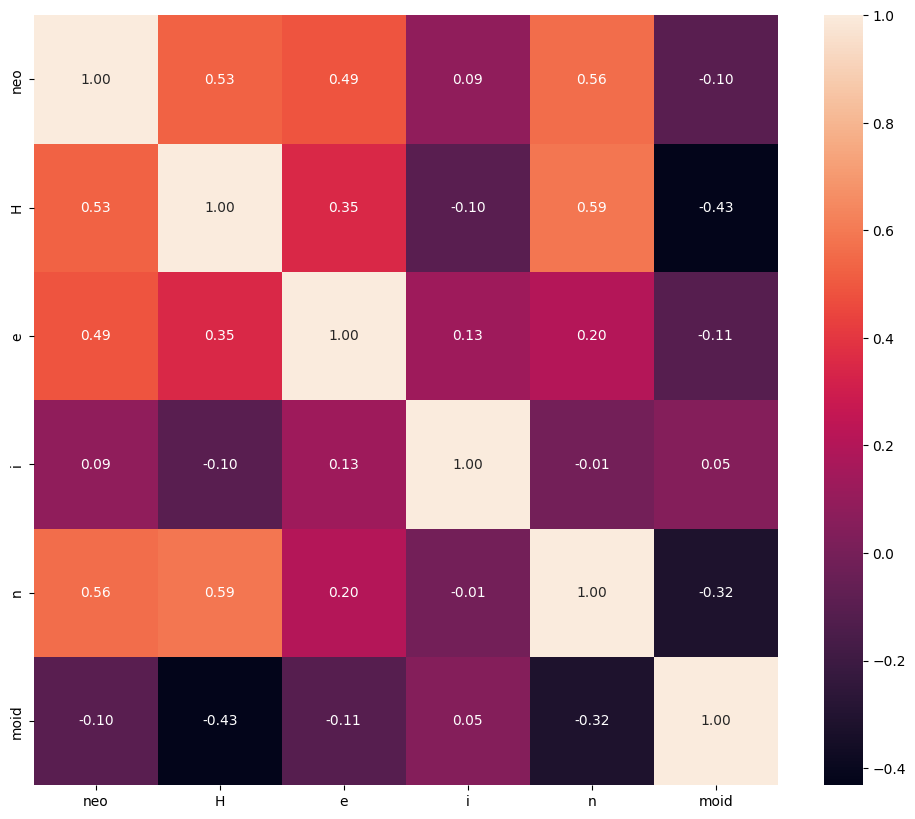

In [84]:
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, fmt=".2f")

In [85]:
hazard = tr.create_pipeline(X_train, y_train, LGBMClassifier(**ri.params_dict['LightGBM_2']))
hazard.fit(X_train, y_train)

/home/athyrson/miniconda3/envs/hpc/lib/python3.13/site-packages/credit_pipeline/training.py:115: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  group_ave = X_copy.replace(mean)
/home/athyrson/miniconda3/envs/hpc/lib/python3.13/site-packages/credit_pipeline/training.py:116: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  group_count = X_copy.replace(count)
/home/athyrson/miniconda3/envs/hpc/lib/python3.13/site-packages/sklearn/compose/_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer

Pipeline(steps=[('fill',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  ['neo', 'H', 'e', 'i', 'n',
                                                   'moid']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  []),
                                                 ('ebe',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['class'])],
                                   verbose_feature_names_out=False)),
                ('le'...
                                                  [])],
                                   verbose_feature_names_out=False)),
                ('classifier',
                 LGBMClassifier(colsample_bytree=0.22534977954592625,
                                is_unbalance=True,
                                learning_rate=0.052227873762946964, max_depth=5,
                                min_child_samples=26, n_estimators=159,
                                n_jobs=-1, num_leaves=12, random_state=880,
                                reg_alpha=0.7438345471808012,
                                reg_lambda=0.46164693905368515,
                                subsample=0.8896599304061413, verbose=-1))])

In [86]:
X_train_tr = hazard[:-3].transform(X_train)

/home/athyrson/miniconda3/envs/hpc/lib/python3.13/site-packages/credit_pipeline/training.py:115: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  group_ave = X_copy.replace(mean)
/home/athyrson/miniconda3/envs/hpc/lib/python3.13/site-packages/credit_pipeline/training.py:116: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  group_count = X_copy.replace(count)


<Axes: >

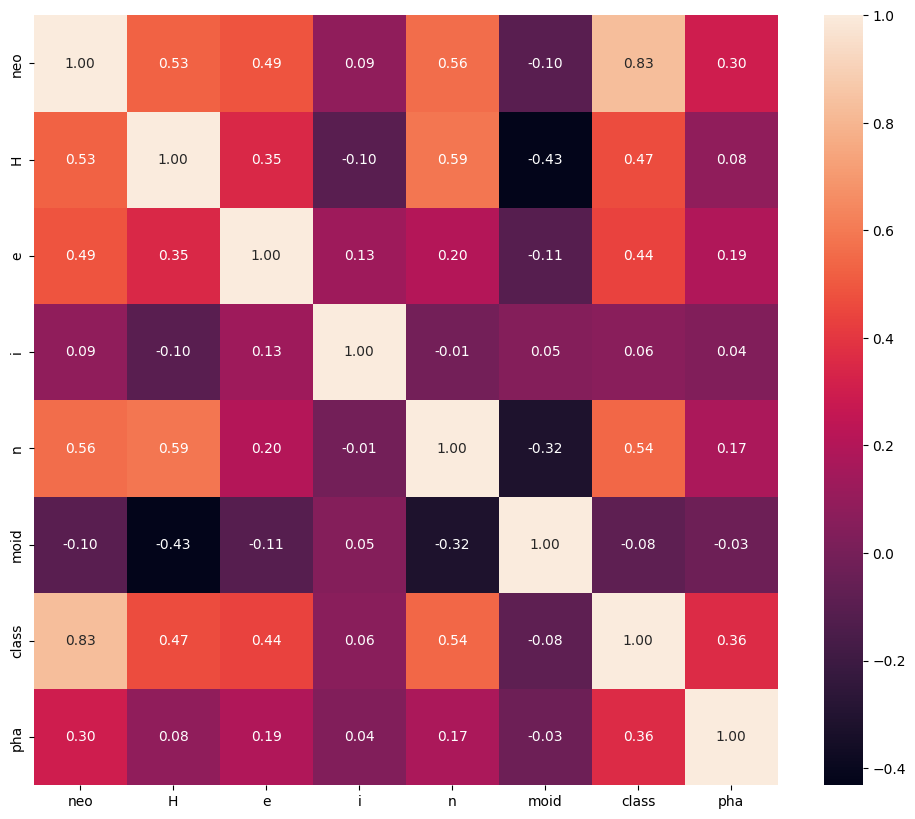

In [87]:
corr = pd.concat([X_train_tr, y_train], axis=1).corr()
plt.figure(figsize=(12, 10))

sns.heatmap(corr, annot=True, fmt=".2f")

In [88]:
y_pred = hazard.predict(X_val)
ri.get_metrics_RI({'haz': hazard}, X_val, y_val, threshold_type='default')

/home/athyrson/miniconda3/envs/hpc/lib/python3.13/site-packages/credit_pipeline/training.py:115: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  group_ave = X_copy.replace(mean)
/home/athyrson/miniconda3/envs/hpc/lib/python3.13/site-packages/credit_pipeline/training.py:116: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  group_count = X_copy.replace(count)
/home/athyrson/miniconda3/envs/hpc/lib/python3.13/site-packages/credit_pipeline/training.py:115: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed i

,haz
Overall AUC,0.981925
KS,0.951537
Balanced Accuracy,0.975594
Accuracy,0.984560
Precision,0.123853
Recall,0.966587
F1,0.219572


Accuracy of the model is:  0.9845603535191024


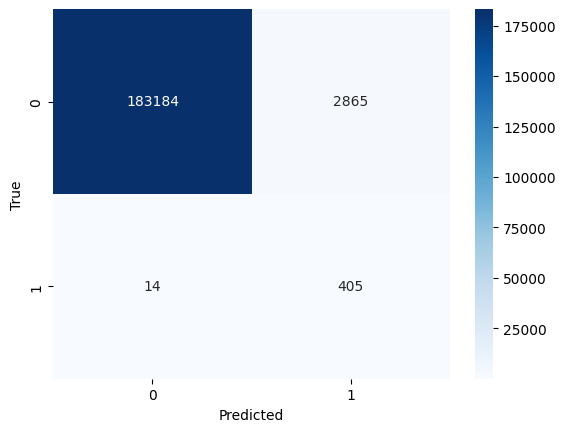

In [89]:
ev.plot_confusion_matrix(y_val, y_pred)

In [90]:
X_val["class"].unique()

array(['MBA', 'APO', 'IMB', 'OMB', 'AMO', 'TJN', 'MCA', 'TNO', 'ATE',
       'AST', 'CEN', 'IEO'], dtype=object)

In [91]:
for c in X_train['class'].unique():
    class_filter_train = X_train["class"] == c
    class_filter_val = X_val["class"] == c
    X_class_val = X_val[class_filter_val]
    X_class_train = X_train[class_filter_train]
    y_class_val = y_val[class_filter_val]
    y_class_train = y_train[class_filter_train]
    print(f"Class: {c} == {round(y_class_train.mean(),3)} in {len(y_class_train)} samples")

Class: MBA == 0.0 in 666210 samples
Class: MCA == 0.0 in 14287 samples
Class: OMB == 0.0 in 21729 samples
Class: APO == 0.139 in 10107 samples
Class: TJN == 0.0 in 6483 samples
Class: IMB == 0.0 in 15743 samples
Class: TNO == 0.0 in 2730 samples
Class: ATE == 0.104 in 1361 samples
Class: AMO == 0.014 in 6751 samples
Class: CEN == 0.0 in 409 samples
Class: IEO == 0.312 in 16 samples
Class: AST == 0.0 in 43 samples


In [92]:
train = pd.concat([X_train, y_train], axis=1)
val = pd.concat([X_val, y_val], axis=1)
train.shape, val.shape

((745869, 8), (186468, 8))

In [93]:
classes_to_drop = train.groupby('class')['pha'].sum()[lambda x: x == 0].index

# Filter out rows where the class is in the identified list
train_filtered = train[~train['class'].isin(classes_to_drop)]
val_filtered = val[~val['class'].isin(classes_to_drop)]

X_train = train_filtered.drop(columns='pha')
y_train = train_filtered['pha']
X_val = val_filtered.drop(columns='pha')
y_val = val_filtered['pha']

In [95]:
pd.concat([X_train, X_val], axis=0)

,neo,H,e,i,n,moid,class
952461,1.0,25.2,0.451332,4.601962,0.405696,0.002090,APO
580337,1.0,23.4,0.412371,5.945912,0.521120,0.048969,APO
945661,1.0,28.3,0.475503,5.797365,0.532087,0.002214,APO
949156,1.0,25.2,0.152258,9.999814,0.756204,0.022992,APO
744379,1.0,22.9,0.403216,8.622778,1.113982,0.040604,ATE
...,...,...,...,...,...,...,...
761725,1.0,23.1,0.658790,5.866468,0.763851,0.008178,APO
138174,1.0,20.4,0.293146,5.238250,0.979413,0.008675,APO
882562,1.0,25.8,0.194143,4.157177,0.755250,0.013357,APO
511001,1.0,20.1,0.176620,29.148363,0.509511,0.461177,AMO


In [49]:
class_dict = {}

for c in X_train['class'].unique():
    print(f"Class: {c}")
    class_filter_train = X_train["class"] == c
    
    class_dict[c] = pd.concat([X_train[class_filter_train], y_train[class_filter_train]], axis=1)


Class: APO
Class: ATE
Class: AMO
Class: IEO


In [50]:
hazard = tr.create_pipeline(X_train, y_train, LGBMClassifier(**ri.params_dict['LightGBM_2']))
hazard.fit(X_train, y_train)

/home/athyrson/miniconda3/envs/hpc/lib/python3.13/site-packages/credit_pipeline/training.py:115: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  group_ave = X_copy.replace(mean)
/home/athyrson/miniconda3/envs/hpc/lib/python3.13/site-packages/credit_pipeline/training.py:116: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  group_count = X_copy.replace(count)
/home/athyrson/miniconda3/envs/hpc/lib/python3.13/site-packages/sklearn/compose/_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer

Pipeline(steps=[('fill',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  ['neo', 'H', 'e', 'i', 'n',
                                                   'moid']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  []),
                                                 ('ebe',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['class'])],
                                   verbose_feature_names_out=False)),
                ('le'...
                                                  [])],
                                   verbose_feature_names_out=False)),
                ('classifier',
                 LGBMClassifier(colsample_bytree=0.22534977954592625,
                                is_unbalance=True,
                                learning_rate=0.052227873762946964, max_depth=5,
                                min_child_samples=26, n_estimators=159,
                                n_jobs=-1, num_leaves=12, random_state=880,
                                reg_alpha=0.7438345471808012,
                                reg_lambda=0.46164693905368515,
                                subsample=0.8896599304061413, verbose=-1))])

In [51]:
ri.get_metrics_RI({'haz': hazard}, X_val, y_val, threshold_type='default')

/home/athyrson/miniconda3/envs/hpc/lib/python3.13/site-packages/credit_pipeline/training.py:115: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  group_ave = X_copy.replace(mean)
/home/athyrson/miniconda3/envs/hpc/lib/python3.13/site-packages/credit_pipeline/training.py:116: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  group_count = X_copy.replace(count)


,haz
Overall AUC,0.999516
KS,0.991938
Balanced Accuracy,0.995851
Accuracy,0.994406
Precision,0.943567
Recall,0.997613
F1,0.969838


/home/athyrson/miniconda3/envs/hpc/lib/python3.13/site-packages/credit_pipeline/training.py:115: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  group_ave = X_copy.replace(mean)
/home/athyrson/miniconda3/envs/hpc/lib/python3.13/site-packages/credit_pipeline/training.py:116: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  group_count = X_copy.replace(count)


Accuracy of the model is:  0.9944061962134251


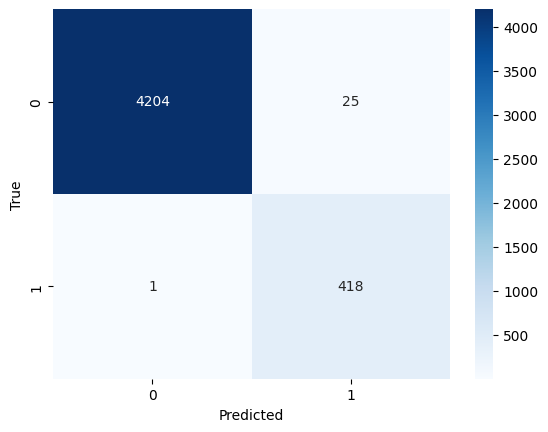

In [52]:
y_pred = hazard.predict(X_val)
ev.plot_confusion_matrix(y_val, y_pred)

In [53]:
for c in X_train['class'].unique():
    class_filter_train = X_train["class"] == c
    class_filter_val = X_val["class"] == c
    X_class_val = X_val[class_filter_val]
    X_class_train = X_train[class_filter_train]
    y_class_val = y_val[class_filter_val]
    y_class_train = y_train[class_filter_train]
    # print(f"Class: {c} == {round(y_class_train.mean(),3)} in train")
    
    auc = ev.f1_score(y_class_val, hazard.predict(X_class_val))
    # auc = ev.roc_auc_score(y_class_val, hazard.predict_proba(X_class_val)[:, 1])
    print(f"Class: {c} == {round(auc, 5)} in val")

/home/athyrson/miniconda3/envs/hpc/lib/python3.13/site-packages/credit_pipeline/training.py:115: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  group_ave = X_copy.replace(mean)
/home/athyrson/miniconda3/envs/hpc/lib/python3.13/site-packages/credit_pipeline/training.py:116: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  group_count = X_copy.replace(count)


Class: APO == 0.97166 in val
Class: ATE == 0.95385 in val
Class: AMO == 0.96296 in val
Class: IEO == 1.0 in val


/home/athyrson/miniconda3/envs/hpc/lib/python3.13/site-packages/credit_pipeline/training.py:115: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  group_ave = X_copy.replace(mean)
/home/athyrson/miniconda3/envs/hpc/lib/python3.13/site-packages/credit_pipeline/training.py:116: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  group_count = X_copy.replace(count)
/home/athyrson/miniconda3/envs/hpc/lib/python3.13/site-packages/credit_pipeline/training.py:115: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed i

Explained Variance Ratio: [0.42854481 0.29312757]

PCA-transformed DataFrame:
             PC1       PC2  pha class
952461  1.034703  0.931076  0.0   APO
580337  0.627209  0.300136  0.0   APO
945661  1.706837  0.860898  0.0   APO
949156  1.742760 -1.088722  0.0   APO
744379  1.284516 -1.047924  0.0   ATE


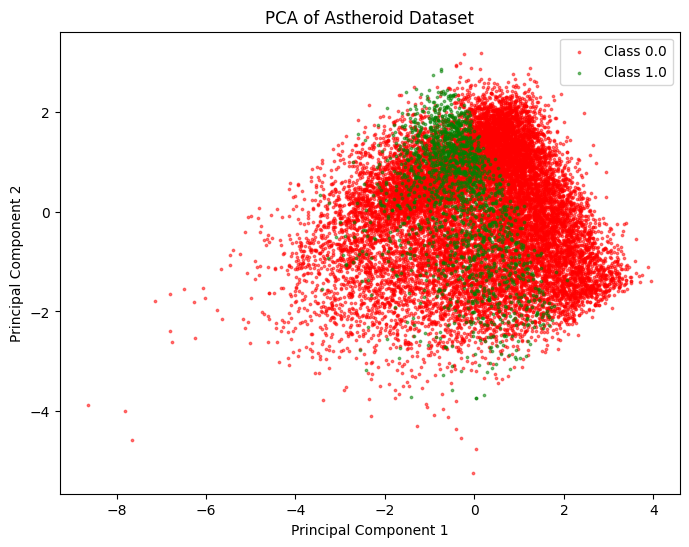

In [68]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler

# Standardize the features (PCA is sensitive to scale)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train.drop(columns=['class']))

# Apply PCA
pca = PCA(n_components=2)  # Reduce to 2 components
X_pca = pca.fit_transform(X_scaled)

# Convert the transformed data back to a DataFrame
X_pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'], index=X_train.index)
X_pca_df['pha'] = y_train
X_pca_df['class'] = X_train['class']
# X_pca_df['target'] = y_train

# Explained variance ratio
explained_variance = pca.explained_variance_ratio_

# Print results
print("Explained Variance Ratio:", explained_variance)
print("\nPCA-transformed DataFrame:")
print(X_pca_df.head())

# Plot the PCA result
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
for label, color in zip(np.unique(y_train), ['r', 'g']):
    plt.scatter(X_pca_df.loc[X_pca_df['pha'] == label, 'PC1'],
                X_pca_df.loc[X_pca_df['pha'] == label, 'PC2'],
                label=f"Class {label}", alpha=0.5, color=color, s=3)

plt.title('PCA of Astheroid Dataset')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()


In [70]:
hazard_pca = tr.create_pipeline(X_pca_df.drop(columns=['pha']), y_train, LGBMClassifier(**ri.params_dict['LightGBM_2']))
hazard_pca.fit(X_pca_df.drop(columns=['pha']), y_train)

/home/athyrson/miniconda3/envs/hpc/lib/python3.13/site-packages/credit_pipeline/training.py:115: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  group_ave = X_copy.replace(mean)
/home/athyrson/miniconda3/envs/hpc/lib/python3.13/site-packages/credit_pipeline/training.py:116: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  group_count = X_copy.replace(count)
/home/athyrson/miniconda3/envs/hpc/lib/python3.13/site-packages/sklearn/compose/_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer

Pipeline(steps=[('fill',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  ['PC1', 'PC2']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  []),
                                                 ('ebe',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['class'])],
                                   verbose_feature_names_out=False)),
                ('le',
                 ColumnTransforme...
                                                  [])],
                                   verbose_feature_names_out=False)),
                ('classifier',
                 LGBMClassifier(colsample_bytree=0.22534977954592625,
                                is_unbalance=True,
                                learning_rate=0.052227873762946964, max_depth=5,
                                min_child_samples=26, n_estimators=159,
                                n_jobs=-1, num_leaves=12, random_state=880,
                                reg_alpha=0.7438345471808012,
                                reg_lambda=0.46164693905368515,
                                subsample=0.8896599304061413, verbose=-1))])

In [71]:
ri.get_metrics_RI({'haz': hazard_pca}, X_pca_df.drop(columns=['pha']), y_train, threshold_type='default')

/home/athyrson/miniconda3/envs/hpc/lib/python3.13/site-packages/credit_pipeline/training.py:115: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  group_ave = X_copy.replace(mean)
/home/athyrson/miniconda3/envs/hpc/lib/python3.13/site-packages/credit_pipeline/training.py:116: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  group_count = X_copy.replace(count)


,haz
Overall AUC,0.871128
KS,0.613405
Balanced Accuracy,0.806143
Accuracy,0.775158
Precision,0.265622
Recall,0.843959
F1,0.404070


In [77]:
class_dict_pca = {}

for c in X_pca_df['class'].unique():
    print(f"Class: {c}")
    class_filter_train = X_pca_df["class"] == c
    
    class_dict_pca[c] = pd.concat([X_pca_df[class_filter_train]], axis=1)

Class: APO
Class: ATE
Class: AMO
Class: IEO


In [78]:
class_dict_pca['AMO']

,PC1,PC2,pha,class
599252,-1.886913,0.144641,0.0,AMO
161998,-1.163227,0.677588,0.0,AMO
939488,0.918045,-1.421944,0.0,AMO
600558,0.473599,-0.219121,0.0,AMO
891933,-2.069603,0.437204,0.0,AMO
...,...,...,...,...
890377,-1.196115,0.588582,0.0,AMO
550351,-1.293789,1.136441,0.0,AMO
657814,-1.097929,0.309459,0.0,AMO
854751,-1.600899,0.706025,0.0,AMO


Explained Variance Ratio: [0.42854481 0.29312757 0.12723344]


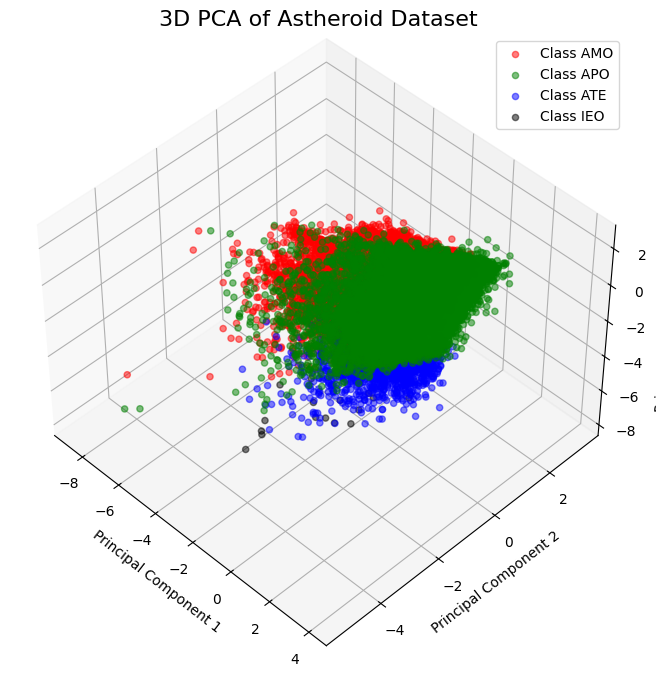

In [56]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # For 3D plotting


# Standardize the features (PCA is sensitive to scale)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train.drop(columns=['class']))

# Apply PCA
pca = PCA(n_components=3)  # Reduce to 3 components
X_pca = pca.fit_transform(X_scaled)

# Convert the transformed data back to a DataFrame
X_pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2', 'PC3'], index=X_train.index)
X_pca_df = pd.concat([X_pca_df, y_train, X_train['class']], axis=1)

# Explained variance ratio
explained_variance = pca.explained_variance_ratio_
print("Explained Variance Ratio:", explained_variance)

# 3D Plot of PCA result
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for each class
for label, color in zip(np.unique(X_train['class']), ['r', 'g', 'b', 'black']):
    ax.scatter(
        X_pca_df.loc[X_pca_df['class'] == label, 'PC1'],
        X_pca_df.loc[X_pca_df['class'] == label, 'PC2'],
        X_pca_df.loc[X_pca_df['class'] == label, 'PC3'],
        label=f"Class {label}", alpha=0.5, color=color
    )

# Add labels and title
ax.set_title('3D PCA of Astheroid Dataset', fontsize=16)
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.legend()
ax.view_init(elev=45, azim=-45)
plt.show()


In [64]:
class_dict_copy = class_dict.copy()

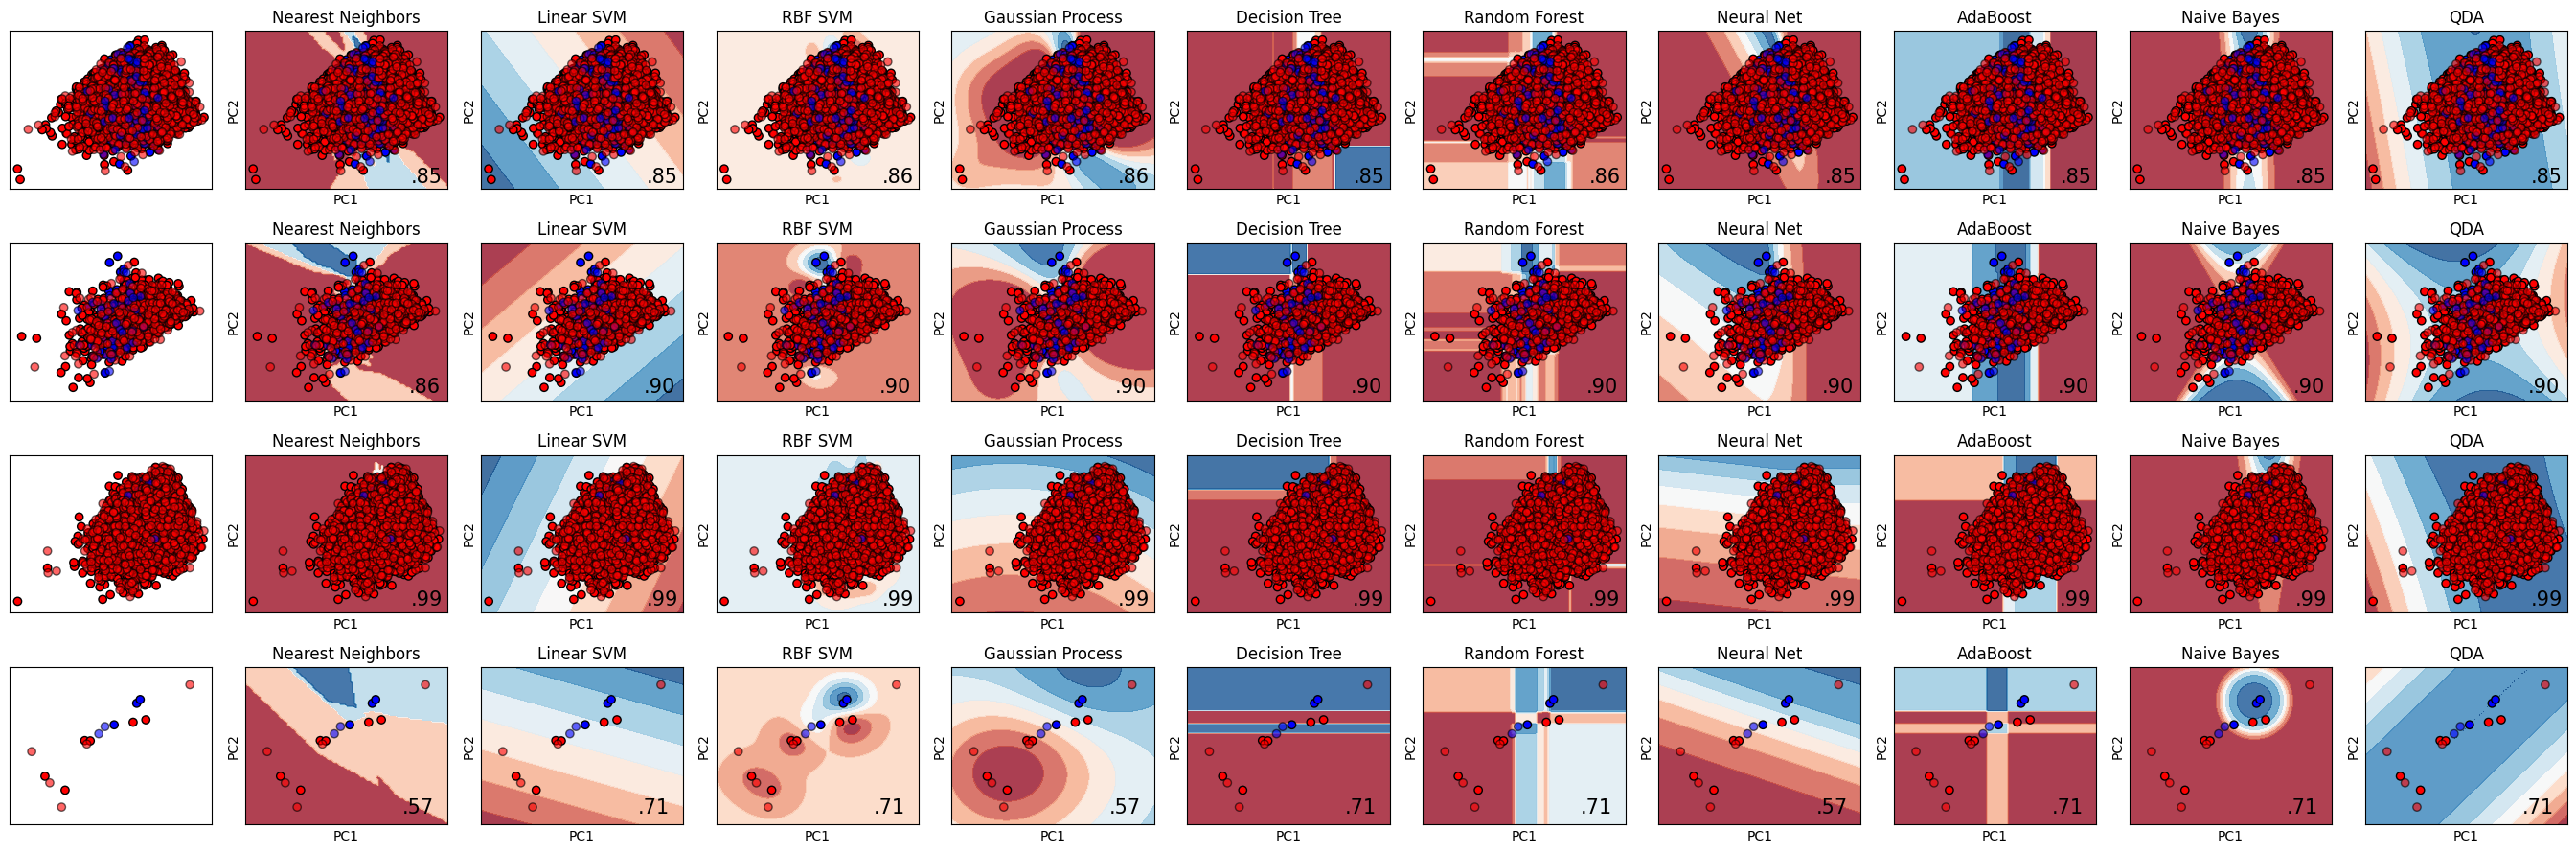

In [79]:
# Code source: Gaël Varoquaux
#              Andreas Müller
# Modified for documentation by Jaques Grobler
# License: BSD 3 clause

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

from sklearn.datasets import make_circles, make_classification, make_moons
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

names = [
    "Nearest Neighbors",
    "Linear SVM",
    "RBF SVM",
    "Gaussian Process",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "AdaBoost",
    "Naive Bayes",
    "QDA",
]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025, random_state=42),
    SVC(gamma=2, C=1, random_state=42),
    GaussianProcessClassifier(1.0 * RBF(1.0), random_state=42),
    DecisionTreeClassifier(max_depth=5, random_state=42),
    RandomForestClassifier(
        max_depth=5, n_estimators=10, max_features=1, random_state=42
    ),
    MLPClassifier(alpha=1, max_iter=1000, random_state=42),
    AdaBoostClassifier(algorithm="SAMME", random_state=42),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
]





figure = plt.figure(figsize=(27, 9))
i = 1
# iterate over datasets
for c, c_df in class_dict_pca.items():
    # preprocess dataset, split into training and test part
    X, y = c_df.drop(['pha', 'class'], axis=1), c_df['pha']
    X_train_temp, X_test_temp, y_train_temp, y_test_temp = train_test_split(
        X, y, test_size=0.4, random_state=42
    )

    x_min, x_max = X.loc[:, 'PC1'].min() - 0.5, X.loc[:, 'PC1'].max() + 0.5
    y_min, y_max = X.loc[:, 'PC2'].min() - 0.5, X.loc[:, 'PC2'].max() + 0.5

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(["#FF0000", "#0000FF"])
    ax = plt.subplot(len(class_dict_pca), len(classifiers) + 1, i)
    # if c_df == 0:
    #     ax.set_title("Input data")
    # Plot the training points
    ax.scatter(X_train_temp.loc[:, 'PC1'], X_train_temp.loc[:, 'PC2'], c=y_train_temp, cmap=cm_bright, edgecolors="k")
    # Plot the testing points
    ax.scatter(
        X_test_temp.loc[:, 'PC1'], X_test_temp.loc[:, 'PC2'], c=y_test_temp, cmap=cm_bright, alpha=0.6, edgecolors="k"
    )
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(class_dict_pca), len(classifiers) + 1, i)

        clf = make_pipeline(StandardScaler(), clf)
        clf.fit(X_train_temp.loc[:,['PC1','PC2']], y_train_temp)
        score = clf.score(X_test_temp.loc[:,['PC1','PC2']], y_test_temp)
        DecisionBoundaryDisplay.from_estimator(
            clf, X.loc[:,['PC1','PC2']], cmap=cm, alpha=0.8, ax=ax, eps=0.5
        )

        # Plot the training points
        ax.scatter(
            X_train_temp.loc[:, 'PC1'], X_train_temp.loc[:, 'PC2'], c=y_train_temp, cmap=cm_bright, edgecolors="k"
        )
        # Plot the testing points
        ax.scatter(
            X_test_temp.loc[:, 'PC1'],
            X_test_temp.loc[:, 'PC2'],
            c=y_test_temp,
            cmap=cm_bright,
            edgecolors="k",
            alpha=0.6,
        )

        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        ax.set_xticks(())
        ax.set_yticks(())
        # if c_df == 0:
        ax.set_title(name)
        ax.text(
            x_max - 0.3,
            y_min + 0.3,
            ("%.2f" % score).lstrip("0"),
            size=15,
            horizontalalignment="right",
        )
        i += 1

plt.tight_layout()
plt.show()

In [80]:
c_df

,PC1,PC2,pha,class
163692,-0.715567,-3.654423,0.0,IEO
546134,2.858150,-1.753689,0.0,IEO
164293,1.863603,-2.750070,0.0,IEO
733845,1.656252,-2.281866,1.0,IEO
770867,1.147167,-2.892457,1.0,IEO
434325,0.939378,-2.943280,1.0,IEO
826327,1.734945,-2.175061,1.0,IEO
958283,-0.415934,-4.354376,0.0,IEO
481816,0.800448,-3.147796,1.0,IEO
418264,0.038655,-4.750036,0.0,IEO
